In [125]:
import pandas as pd
import json
import string
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

In [88]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Antonio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
pd.set_option('mode.chained_assignment', None)

In [2]:
data_set = pd.read_csv("../../../dados/movies_metadata.csv")

C:\Users\Antonio\AppData\Local\Temp\ipykernel_192\1955905771.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data_set = pd.read_csv("../../../dados/movies_metadata.csv")


## Definindo apenas para usar linguagem em inglês

In [4]:
data_set_en = data_set.query("original_language == 'en'")

## Extrair o primeiro genero do campo genres

In [34]:
def extrair_primeiro_genero( texto ):
    txt = texto.replace("'", '"')
    lista_generos = json.loads(txt)
    if isinstance(lista_generos, list) and len(lista_generos) > 0:
        genero = lista_generos[0]
        return genero["name"]
    else:
        return "Unknown"

In [35]:
data_set_en["genero"] = data_set_en["genres"].apply(extrair_primeiro_genero)

## Extrair o genero_id com base na lista de generos existentes

In [80]:
lista_generos = list(data_set_en["genero"].unique())

In [47]:
def extrair_genero_id( genero ):
    global lista_generos
    num_genero = 11
    try:
        num_genero = lista_generos.index(genero)
    except: 
        pass
    return num_genero

In [52]:
data_set_en["genero_id"] = data_set_en["genero"].apply(extrair_genero_id)

In [54]:
movies = data_set_en[["original_title", "genero", "genero_id", "overview"]]

## Verificar quantidade de filmes por categoria

In [58]:
generos_agrupados = movies.groupby("genero").count().sort_values(ascending=True, by="genero_id")

<Axes: ylabel='genero'>

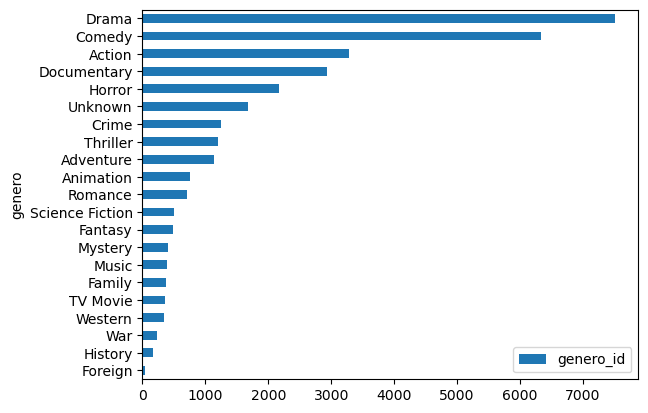

In [59]:
generos_agrupados.plot.barh(y="genero_id")

## Remover os caracteres \n \r \t

In [61]:
trans = str.maketrans('\n\r\t', '   ')
movies["overview_no_enter"] = movies["overview"].str.translate(trans)

## Remover contrações em Inglês

In [63]:
contraction_dict = {
                    "aren't": "are not",		"can't": "can not",		"could've": "could have",
                    "couldn't": "could not",	"daren't": "dare not",	"didn't": "did not",
                    "doesn't": "does not",		"don't": "do not",		"hadn't": "had not",
                    "hasn't": "has not",		"haven't": "have not",	"he's": "he is",
                    "how'd": "how had",			"how're": "how are",	"how's": "how is",
                    "how've": "how have",		"i'd": "i had",			"i'm": "i am",
                    "i've": "i have",			"isn't": "is+ not",		"it's": "it is",
                    "might've": "might have",	"mightn't": "might not",	"must've": "must have",
                    "mustn't": "must not",		"needn't": "need not",	"oughtn't": "ought not",
                    "shan't": "shall not",		"she'd": "she had",		"she's": "she is",
                    "should've": "should have",	"shouldn't": "should not",	"that'd": "that had",
                    "thats's": "that is",		"there'd": "there had",	"there's": "there is",
                    "they'd": "they had",		"they're": "you are",	"they've": "they have",
                    "wasn't": "was+ not",		"we'd": "we had",		"we're": "we are",
                    "we've": "we have",			"weren't": "were not",	"what'd": "what had",
                    "what're": "what are",		"what's": "what is",	"what've": "what have",
                    "when'd": "when had",		"when're": "when are",	"when's": "when is",
                    "when've": "when have",		"where'd": "where had",	"where're": "where are",
                    "where's": "where is",		"where've": "where have",	"who'd": "who had",
                    "who're": "who are",		"who's": "who is",		"who've": "who have",
                    "why'd": "why had",			"why're": "why are",	"why's": "why is",
                    "why've": "why have",		"would've": "would have",	"wouldn't": "would not",
                    "you're": "you are",		"you've": "you have",	"'cause": "because", 
                    "ain't": "is not", 			"aren't": "are not",	"can't": "cannot", 
                    "could've": "could have",	"he's": "he is",		"how'll": "how will",
                    "i'll": "i will",			"it'll": "it will",		"it's": "it is", 
                    "she'll": "she will",		"she's": "she is",		"that'll": "that will",
                    "there'll": "there will",	"they'll": "they will",	"they're": "they are",
                    "we'll": "we will",			"we're": "we are",		"what'll": "what will",
                    "when'll": "when will",		"where'll": "where will",	"who'll": "who will",
                    "yo're": "you are",			"you'll": "you will"
            }

In [75]:
def remove_contractions( text ):
    global contraction_dict
    if isinstance(text, str):
        text = text.lower()
        for contracao_chave in contraction_dict.keys():
            contracao_valor = contraction_dict[contracao_chave]
            text = text.replace(contracao_chave, contracao_valor)
        text = text.replace("\'s", " have")
        return text
    else:
        return ""

In [84]:
movies["overview_no_contractions"] = movies["overview_no_enter"].apply(remove_contractions)

## Remover as pontuações

In [85]:
trans = str.maketrans('', '', string.punctuation)
movies["overview_no_punctuation"] = movies["overview_no_contractions"].str.translate(trans)

## Remover as stopwords

In [90]:
stopwords = nltk.corpus.stopwords.words('english')

In [91]:
def remove_stop_words( text ):
    novas_palavras = []
    palavras = text.split(" ")
    for palavra in palavras:
        if palavra not in stopwords:
            novas_palavras.append(palavra)
    return " ".join(novas_palavras)

In [94]:
movies["overview_no_stopwords"] = movies["overview_no_punctuation"].apply(remove_stop_words)

## Definindo variavel textos

In [96]:
textos = movies["overview_no_stopwords"]

## Criar o Bag of words

In [137]:
vetorizador = TfidfVectorizer(max_features=1000)
bow = vetorizador.fit_transform( textos )
vocabulario = vetorizador.get_feature_names_out()

In [138]:
bow_matrix = pd.DataFrame.sparse.from_spmatrix(bow, columns=vocabulario)

## Separar os conjuntos em treinamento e testes

In [139]:
train_x, test_x, train_y, test_y = train_test_split(bow_matrix, movies["genero_id"], random_state=50, test_size=0.25)

In [140]:
print("train_x: ", train_x.shape)
print("test_x: ", test_x.shape)
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_x:  (24201, 1000)
test_x:  (8068, 1000)
train_y:  (24201,)
test_y:  (8068,)


## Criar modelo aprendizagem de maquina

In [141]:
model = LinearSVC(random_state = 50)

In [142]:
model.fit(train_x, train_y)

C:\Users\Antonio\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(random_state=50)

In [143]:
model.score(test_x, test_y)

0.39439762022806146